In [ ]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1627460240146_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
conf = SparkConf()
conf.set("spark.executor.memory", "16g")
conf.set("spark.driver.memory", "16g")
conf.set("spark.sql.session.timeZone","UTC")
conf.set("spark.driver.maxResultSize", "4g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)
sc = spark.sparkContext
sqlContext = SQLContext(sc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### To run in EMR

In [ ]:
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("sklearn")
sc.install_pypi_package("pandas==0.25.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: /var/lib/livy/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


You are using pip version 9.0.1, however version 21.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

### To run in EMR and EC2

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import *
import time

# For feature engineering and data cleanup
from pyspark.sql.functions import to_date, dayofweek, hour, col, avg
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ByteType, DateType, TimestampType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

# For ML models and predictions
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Import data

### To run on EC2 - for testing purposes

In [ ]:
# Create a small file for learning and building purposes

#100k samples
# !head -n 100001 "idc_train.csv" > "idc_train_100001.csv"
# training_file ="idc_train_100001.csv"
# test_file = "idc_test.csv"

### Full Data Files (EMR and EC2)

In [ ]:
# For EC2
# training_file = "idc_train.csv" #For full training data
# test_file = "idc_test.csv"

# For EMR
training_file = "/user/hadoop/idc_train.csv"
test_file = "/user/hadoop/idc_test.csv"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load training data

In [ ]:
t = time.time()
#read a CSV file into a Spark dataframe with an explicit scheme, Create schema and use it to read the file
schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

X_train = spark.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(training_file)
print('Running time', time.time() - t , 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 1.7621541023254395 s

## Load Test Data

In [ ]:
t = time.time()

# Read a CSV file into a Spark dataframe with an explicit schema
# Test data does not have fare_amount
schema = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

X_test = spark.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(test_file)

print('Running time', time.time() - t)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.04953193664550781

# Preprocess: Workout the Data

##  Drop/adjust missing data and inconsistent values:
    - Drop duplicates
    - Remove rows with erroneous negative fare
    - Replace missing/zero values with average of the feature

In [ ]:
def drop_duplicates(X):
    processed_X = X.dropDuplicates() #Drop duplicates
    return processed_X

def filter_positive_fare_amount(X):
    processed_X = X.filter(X_train['fare_amount'] > 0) #Remove rows with erroneous negative fare
    return processed_X

# Imputation - Replace missing/zero values with average of the feature
def data_imputation(X):
    for i in range(len(X.columns)):
        mean = X.agg( avg(col(X.columns[i] )) ).first()[0] #find the mean for the column
        # Fill with mean if there is missing value
        X = X.na.fill(value=mean,subset=[ X.columns[i] ]) 
        if X.columns[i] != 'pickup_datetime':
            X = X.withColumn(X.columns[i],when( X[i] == 0.0 , mean ).otherwise( X[i] ) )
    return X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Pre-process Traning Dataset: drop duplicates, filter erroneous data, data imputaton

In [ ]:
t = time.time()

X_train = data_imputation(X_train)
X_train = drop_duplicates(X_train)
X_train = filter_positive_fare_amount(X_train)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 303.7995750904083 s

### Add label column (high fare) to training set

In [ ]:
def add_label_column(X):
    engineered_X = X.withColumn("high_fare", (X_train.fare_amount>=10).cast("Byte")) #add high fare
    return engineered_X

X_train = add_label_column(X_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Pre-process Test Dataset: data imputation

In [ ]:
X_test = data_imputation(X_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Feature engineering: ride_length, features from timestamps

In [ ]:
# modify pickup time in a way it can be used
def add_features_from_timestamps(X):
    engineered_X = X.withColumn("month", month(X['pickup_datetime']).cast("Integer"))
    engineered_X = engineered_X.withColumn("day_in_month", dayofmonth(engineered_X['pickup_datetime']).cast("Integer"))
    engineered_X = engineered_X.withColumn("day_in_week", dayofweek(engineered_X['pickup_datetime']).cast("Integer"))
    engineered_X = engineered_X.withColumn("hour", hour(engineered_X['pickup_datetime']).cast("Integer"))
    engineered_X = engineered_X.withColumn("year", year(engineered_X['pickup_datetime']).cast("Integer"))
    return engineered_X

# New column, distance from pickup to dropoff in km
def add_eudlidean_distance(X):
    R = 6373.0

    lat1 = radians(X['pickup_latitude'])
    lon1 = radians(X['pickup_longitude'])
    lat2 = radians(X['dropoff_latitude'])
    lon2 = radians(X['dropoff_longitude'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    engineered_X = X.withColumn("distance_KM", distance.cast("Float"))
    return engineered_X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Training set: Feature engineering

In [ ]:
t = time.time()
X_train = add_features_from_timestamps(X_train)
X_train = add_eudlidean_distance(X_train)
print(X_train.columns)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'high_fare', 'month', 'day_in_month', 'day_in_week', 'hour', 'year', 'distance_KM']
Running time 0.16466593742370605 s

### Test Set: feature engineering

In [ ]:
t = time.time()
X_test = add_features_from_timestamps(X_test)
X_test = add_eudlidean_distance(X_test)
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.13475704193115234 s

## Filterng and removing outliers

In [ ]:
t = time.time()

#Remove rows with erroneous negative or zero distance. Will only be removed on training data
X_train = X_train.filter(X_train['distance_KM'] > 0.0001) 
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.011860132217407227 s

In [ ]:
num_rows,num_cols = X_train.count(),len(X_train.columns)
print(num_rows,num_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

19777603 15

## Study distribution for outlier identification

First, lets plot the longitude and latitude coordinates to see the distribution. then we will manually decide which threshold to apply in order to remove outliers, if any at all.  Note we are already filtering in the plot by setting xlim, ylim and not displaying far away outliers.

In [ ]:
t = time.time()
df = X_train.sample(1.0 * 10100 / num_rows).limit(10000).toPandas() #sample 10k to study training data
print('Running time', time.time() - t, 's' )

Running time 8.463862657546997 s


In [ ]:
dft = X_test.toPandas()

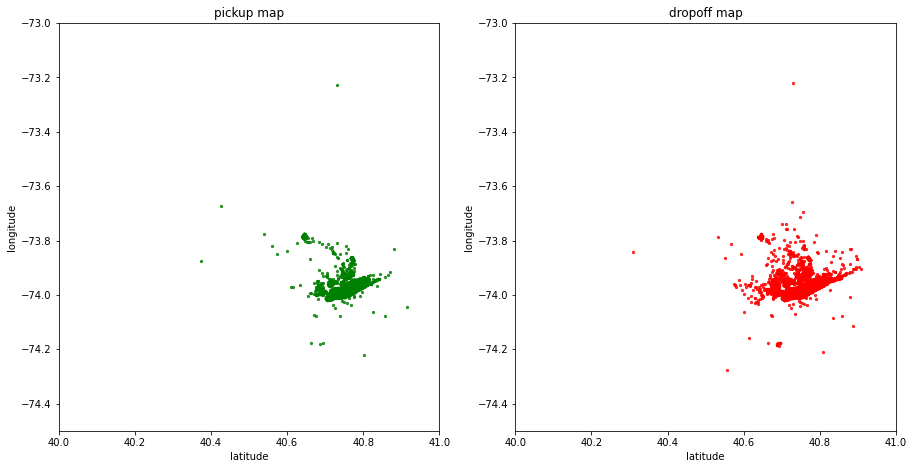

Running time 0.5596232414245605 s


In [ ]:
t = time.time()

fig,ax = plt.subplots(1, 2, figsize=(15,7.5))

#x_min = df.pickup_latitude.min(); x_max = df.pickup_latitude.max()
#y_min = df.pickup_longitude.min() ; y_max = df.pickup_longitude.max()
ax[0].set_xlim(40,41) 
ax[0].set_ylim(-74.5,-73) 
ax[0].scatter(df['pickup_latitude'], df['pickup_longitude'], s=5, alpha=0.8, color='green', label='all crimes')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].set_title('pickup map')

#x_min = df.dropoff_latitude.min(); x_max = df.dropoff_latitude.max()
#y_min = df.dropoff_longitude.min() ; y_max = df.dropoff_longitude.max()
ax[1].set_xlim(40, 41) 
ax[1].set_ylim(-74.5,-73) 
ax[1].scatter(df['dropoff_latitude'], df['dropoff_longitude'], s=5, alpha=0.8, color='red', label='all crimes')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].set_title('dropoff map')
plt.show()

print('Running time', time.time() - t, 's' )

Lets apply the following thresholds:

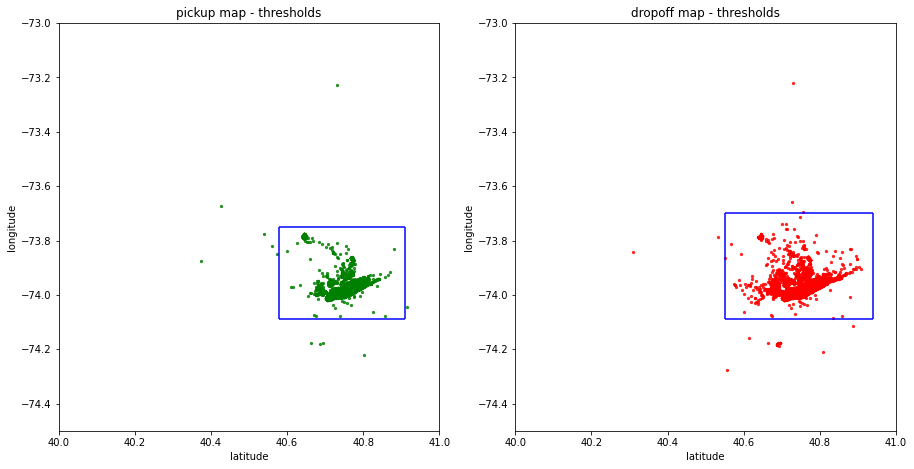

Running time 0.4377877712249756 s


In [ ]:
t = time.time()

fig,ax= plt.subplots(1, 2, figsize=(15,7.5))

#pickup
ax[0].set_xlim(40,41) 
ax[0].set_ylim(-74.5,-73) 

ax[0].scatter(df['pickup_latitude'], df['pickup_longitude'], s=5, alpha=0.8, color='green', label='all crimes')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].set_title('pickup map - thresholds')

ax[0].hlines(y = [-73.75,-74.09], xmin = [40.58,40.58], xmax=[40.91,40.91],color = 'blue')
ax[0].vlines(x = [40.58,40.91], ymin = [-74.09,-74.09], ymax=[-73.75,-73.75],color = 'blue')

#dropoff
ax[1].set_xlim(40, 41) 
ax[1].set_ylim(-74.5,-73) 
ax[1].scatter(df['dropoff_latitude'], df['dropoff_longitude'], s=5, alpha=0.8, color='red', label='all crimes')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].set_title('dropoff map - thresholds')
ax[1].hlines(y = [-73.7,-74.09], xmin = [40.55,40.55], xmax=[40.94,40.94],color = 'blue')
ax[1].vlines(x = [40.55,40.94], ymin = [-74.09,-74.09], ymax=[-73.7,-73.7],color = 'blue')

plt.show()

print('Running time', time.time() - t, 's' )

Now finally lets check the distance distribution and the threshold we decided to put. Note we are already filtering in the plot by setting ylim and not displaying far away outliers.

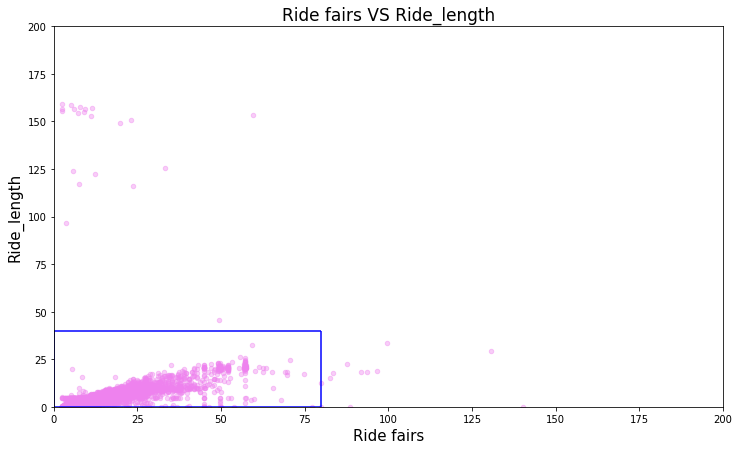

Running time 0.37041544914245605 s


In [ ]:
t = time.time()

df.plot(kind = 'scatter',x= 'fare_amount',y = 'distance_KM',marker = 'o',alpha=0.4,color='violet',figsize=(12,7))
plt.ylim(0,200) 
plt.xlim(0,200) 
plt.title('Ride fairs VS Ride_length',fontsize = 17)
plt.xlabel('Ride fairs',fontsize = 15)
plt.ylabel('Ride_length',fontsize = 15)
plt.hlines(y = [0,40], xmin = [0,0], xmax=[80,80],color = 'blue')
plt.vlines(x = [0,80], ymin = [0,0], ymax=[40,40],color = 'blue')
plt.show()

print('Running time', time.time() - t, 's' )

### Remove outliers from training dataset

In [ ]:
# #pickup thresholding
X_train = X_train.filter((X_train['pickup_longitude'] >= -74.09) &(X_train['pickup_longitude'] <= -73.75))
X_train = X_train.filter( (X_train['pickup_latitude'] >= 40.58) & (X_train['pickup_latitude'] <= 40.91))

#dropoff thresholding
X_train = X_train.filter( (X_train['dropoff_longitude'] >= -74.09) &(X_train['pickup_longitude'] <= -73.7))
X_train = X_train.filter( (X_train['dropoff_latitude'] >= 40.55) & (X_train['dropoff_latitude'] <= 40.94))

#distance in km thresholding
X_train = X_train.filter(X_train['distance_KM'] <= 40)
X_train = X_train.filter(X_train['fare_amount'] <= 80)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Build Feature Vectors and Normalize

In [ ]:
#Transform features into a vector using VectorAssembler. Not using target, nor transformed features such as "key", "pickup_datetime" 

assembler = VectorAssembler()\
        .setInputCols(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count",\
                      "month","day_in_month","day_in_week","hour","year","distance_KM"])\
        .setOutputCol("vectorized_features")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Standarize features with StandardScaler
scaler = StandardScaler(withMean=True, withStd=True)\
        .setInputCol("vectorized_features")\
        .setOutputCol("normalized_features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Execute pipeline for Training Data

In [ ]:
t = time.time()

assembler_df_train = assembler.transform(X_train)
scaler_model = scaler.fit(assembler_df_train)
training_scaler_df = scaler_model.transform(assembler_df_train)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 403.88587737083435 s

### Execute pipeline for Test Data

In [ ]:
assembler_df_test = assembler.transform(X_test)
testing_scaler_df = scaler_model.transform(assembler_df_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Plot information from data
Create the following plots (with a sample of 10,000):
1) Distribution of ride fairs.
2) Ride fare vs. ride length.
3) Average ride length per pick up time hour of the day (x-axis = 24 hours).

In [ ]:
df = X_train.sample(1.0*10100/num_rows).limit(10000).toPandas()

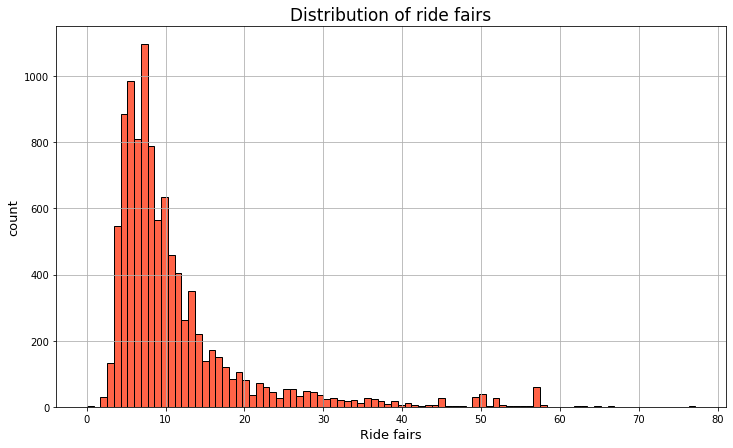

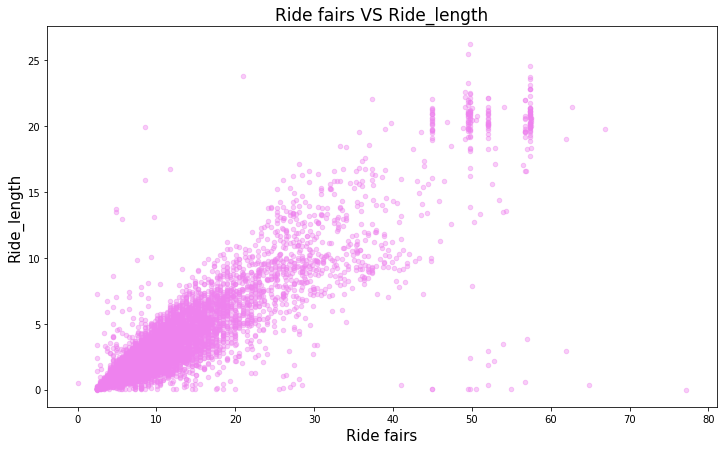

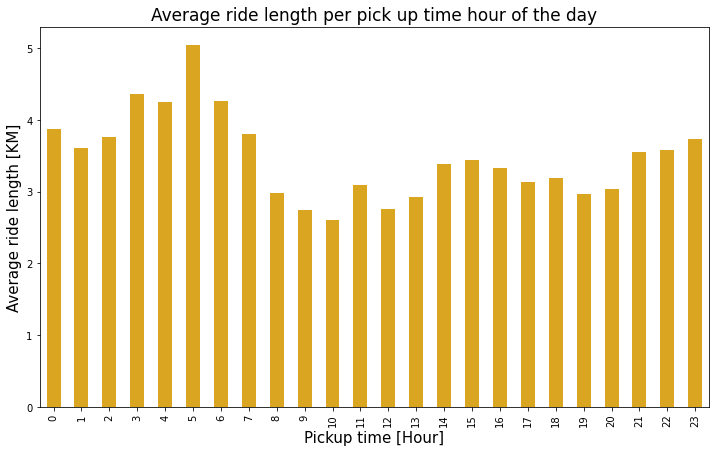

In [ ]:
# Distribution of ride fairs:
df.fare_amount.hist(bins = 90,edgecolor= 'black',color='tomato',figsize=(12,7))
plt.title('Distribution of ride fairs',fontsize = 17)
plt.xlabel('Ride fairs',fontsize = 13)
plt.ylabel('count',fontsize = 13)
plt.show()
print('\n')

#Ride fairs VS Ride_length:
df.plot(kind = 'scatter',x= 'fare_amount',y = 'distance_KM',marker = 'o',alpha=0.4,color='violet',figsize=(12,7))
plt.title('Ride fairs VS Ride_length',fontsize = 17)
plt.xlabel('Ride fairs',fontsize = 15)
plt.ylabel('Ride_length',fontsize = 15)
plt.show()
print('\n')

# Avg ride length per pickup time
df.groupby(['hour'])['distance_KM'].mean().plot.bar(color='goldenrod',figsize=(12,7))
plt.title('Average ride length per pick up time hour of the day',fontsize = 17)
plt.xlabel('Pickup time [Hour]',fontsize = 15)
plt.ylabel('Average ride length [KM]',fontsize = 15)
plt.show()

# MLib Model training - EMR 1 Worker

## Split Training to Train and Validation Set

In [ ]:
t = time.time()
X_training, X_validation = training_scaler_df.randomSplit([0.8, 0.2], seed = 2021 )
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.041779518127441406 s

## Logistic Regression

#### Model Training and Validation

In [ ]:
t = time.time()

# Logistic Regression
lr = LogisticRegression( featuresCol = 'normalized_features', labelCol = 'high_fare', maxIter=15, regParam=0.01, elasticNetParam=0.8 )
lrModel = lr.fit(X_training)
lr_validation_predictions = lrModel.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 507.1649284362793 s

#### Logistic Regression: Model evaluation - Area Under ROC

In [ ]:
t = time.time()

#Area Under ROC

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(lr_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.9360665169748249
Running time 458.3318405151367 s

#### Logistic regression Results: Confusion matrix

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = lr_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2245929.  110647.]
 [ 373192. 1130151.]]
Running time 554.199414730072 s

## Decision Tree

#### Mode training and Validation

In [ ]:
t = time.time()

decision_tree = DecisionTreeClassifier(labelCol="high_fare", featuresCol="normalized_features", maxDepth=5, maxBins=20, minInstancesPerNode=2, minInfoGain=0.1)  
dtModel = decision_tree.fit(X_training)
dt_validation_predictions = dtModel.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 985.3168013095856 s

#### Decision Tree: model evaluation - Area Under ROC

In [ ]:
t = time.time()

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(dt_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.8473643836922042
Running time 459.36165738105774 s

#### Decision Tree Results: Confusion Matrix 

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = dt_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2193135.  163441.]
 [ 355296. 1148047.]]
Running time 535.5023295879364 s

## Random Forest

#### Model training and Validation

In [ ]:
t = time.time()

random_forest = RandomForestClassifier(labelCol="high_fare", featuresCol="normalized_features", numTrees=25, maxDepth=10)  

rf_model = random_forest.fit(X_training)
rf_validation_predictions = rf_model.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 1830.7594711780548 s

#### Random Forest: Model evaluation - Area Under ROC

In [ ]:
t = time.time()

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(rf_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.9455601019779449
Running time 466.82086873054504 s

#### Random Forest Results: Confusion Matrix 

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = rf_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2196669.  159907.]
 [ 272191. 1231152.]]
Running time 554.9318630695343 s

# MLib Model training - EMR 6 Workers

## Split Training to Train and Validation Set

In [ ]:
t = time.time()
X_training, X_validation = training_scaler_df.randomSplit([0.8, 0.2], seed = 2021 )
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.015278100967407227 s

## Logistic Regression

#### Model Training and Validation

In [ ]:
t = time.time()

# Logistic Regression
lr = LogisticRegression( featuresCol = 'normalized_features', labelCol = 'high_fare', maxIter=15, regParam=0.01, elasticNetParam=0.8 )
lrModel = lr.fit(X_training)
lr_validation_predictions = lrModel.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 292.12192368507385 s

#### Logistic Regression: Model evaluation - Area Under ROC

In [ ]:
t = time.time()

#Area Under ROC

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(lr_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.9360667879812692
Running time 94.90846014022827 s

#### Logistic regression Results: Confusion matrix

#### Logistic regression Results: Confusion matrix

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = lr_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2244969.  111574.]
 [ 372992. 1130468.]]
Running time 163.77626872062683 s

## Decision Tree

#### Mode training and Validation

In [ ]:
t = time.time()

decision_tree = DecisionTreeClassifier(labelCol="high_fare", featuresCol="normalized_features", maxDepth=5, maxBins=20, minInstancesPerNode=2, minInfoGain=0.1)  
dtModel = decision_tree.fit(X_training)
dt_validation_predictions = dtModel.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 331.93098044395447 s

#### Decision Tree: model evaluation - Area Under ROC

In [ ]:
t = time.time()

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(dt_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.8473643836922042
Running time 81.17938375473022 s

#### Decision Tree Results: Confusion Matrix 

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = dt_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2192537.  164006.]
 [ 355150. 1148310.]]
Running time 154.74041962623596 s

## Random Forest

#### Model training and Validation

In [ ]:
t = time.time()

random_forest = RandomForestClassifier(labelCol="high_fare", featuresCol="normalized_features", numTrees=25, maxDepth=10)  

rf_model = random_forest.fit(X_training)
rf_validation_predictions = rf_model.transform(X_validation)

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 512.490166425705 s

#### Random Forest: Model evaluation - Area Under ROC

In [ ]:
t = time.time()

evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')
print('X_validation AUC: ',evaluator.evaluate(rf_validation_predictions))

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

X_validation AUC:  0.9455677714804989
Running time 92.07283163070679 s

#### Random Forest Results: Confusion Matrix 

In [ ]:
t = time.time()
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = rf_validation_predictions.select(['prediction','high_fare']).withColumn('label', col('high_fare').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[2196399.  160144.]
 [ 271916. 1231544.]]
Running time 154.7771463394165 s

# Model Predictions

The model we will choose is the one created with Random Forest algorithm (94.7% AUC).

In [ ]:
t = time.time()
lr_test_predictions = lrModel.transform(testing_scaler_df)
rf_test_predictions = rf_model.transform(testing_scaler_df)
print('Running time', time.time() - t, 's' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.10668110847473145 s

In [ ]:
lr_test_predictions = lr_test_predictions.withColumn("k", lr_test_predictions.key.cast("Decimal(15,0)"))
lr_test_predictions = lr_test_predictions.withColumnRenamed('prediction', 'high_fare')
lr_test_predictions = lr_test_predictions.select(['k','high_fare'])
lr_test_predictions = lr_test_predictions.withColumnRenamed('k', 'key')
# lr_test_predictions.show(10)

rf_test_predictions = rf_test_predictions.withColumn("k", rf_test_predictions.key.cast("Decimal(15,0)"))
rf_test_predictions = rf_test_predictions.withColumnRenamed('prediction', 'high_fare')
rf_test_predictions = rf_test_predictions.select(['k','high_fare'])
rf_test_predictions = rf_test_predictions.withColumnRenamed('k', 'key')

rf_test_predictions.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+
|     key|high_fare|
+--------+---------+
|19990001|      0.0|
|19990002|      1.0|
|19990003|      0.0|
|19990004|      0.0|
|19990005|      0.0|
|19990006|      0.0|
|19990007|      0.0|
|19990008|      0.0|
|19990009|      0.0|
|19990010|      0.0|
+--------+---------+
only showing top 10 rows

### Write to csv

In [ ]:
# lr_test_predictions.repartition(1) \
#   .write \
#   .mode('overwrite') \
#   .option('header', 'true') \
#   .option('sep',',') \
#   .csv('s3://aws-logs-735929014102-us-east-1/elasticmapreduce/lr_GilZeevi_203909320_JoelLiurner_346243579.csv')

rf_test_predictions.repartition(1) \
  .write \
  .mode('overwrite') \
  .option('header', 'true') \
  .option('sep',',') \
  .csv('s3://aws-logs-735929014102-us-east-1/elasticmapreduce/rm_GilZeevi_203909320_JoelLiurner_346243579.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark.stop()